In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import scipy.stats as st
from sklearn.metrics import f1_score

def bootstrap_score(predictions, gold, it = 100, alpha = 0.95):
    scores = []
    for _ in range(it):
        bootstrap_sample_index = np.random.choice(predictions, size= predictions.shape)
        sample_score = f1_score(gold[bootstrap_sample_index],predictions[bootstrap_sample_index], average='weighted')
        scores.append(sample_score) 
    scores = np.array(scores)
    conf_interval = st.t.interval(alpha, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores))
    print(conf_interval)
    print('bootstrap score for model ', scores.mean(),'+/- ', scores.mean() - conf_interval[0])
    return conf_interval

In [3]:
model_dir = 'code_submission/' # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
def predict(model, X_test):
    preds = model.predict(X_test)
    preds = tf.argmax(preds, axis=1)
    preds = preds.numpy()
    return preds 

In [5]:
def plot_history(history, name):
    N = len(history.history["loss"])
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    ax1.plot(np.arange(0, N), history.history["loss"],'g',label="train loss")
    ax1.plot(np.arange(0, N), history.history["val_loss"],'r',label="validation loss")
    ax2.plot(np.arange(0, N), history.history["accuracy"],'g',label="train accuracy")
    ax2.plot(np.arange(0, N), history.history["val_accuracy"],'r',label="validation accuracy")
    ax1.set_xlabel("Epoch #")
    ax2.set_xlabel("Epoch #")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    ax1.set_title("Training loss of "+ name)
    ax1.legend(loc="lower left")
    ax2.legend(loc="lower left")
    f.suptitle('Results on the public dataset')
    plt.show()


In [6]:
data_name = 'flower_data' 
data_dir = 'public_data' 
# !ls $data_dir*

In [7]:
from data_io import read_data
data, meta_data = read_data(data_dir)

###-------------------------------------###
### Checking Data
###-------------------------------------###


-------------------------------------
[+] Your dataset is in perfect format
-------------------------------------


###-------------------------------------###
### Loading Data
###-------------------------------------###


-------------------------------------
[+] Data loaded successfully
-------------------------------------


###-------------------------------------###
### Loading Images
###-------------------------------------###


-------------------------------------
[+] Images loaded successfully
-------------------------------------




In [8]:
x_train = data['train_images']  
y_train = data['train_labels_num']

x_test = data['test_images']
y_test = data['test_labels_num']

In [9]:
data = np.concatenate((x_train, x_test))
labels = np.concatenate((y_train, y_test))

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, shuffle=True)

In [11]:
del data 
del labels

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout 
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [13]:
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)

In [14]:
def get_augmented_flow(rescale = True, batch_size= 32):
    if rescale : 
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=90,
            # width_shift_range=0.5,
            # height_shift_range=0.5,
            #brightness_range=[0.2,1.0],
            zoom_range=[0.5,1.0],
            fill_mode='nearest',
            horizontal_flip=True,
            vertical_flip=True,
        )
        test_datagen = ImageDataGenerator(rescale=1./255)
    else : 
        datagen = ImageDataGenerator(
            rotation_range=90,
            # width_shift_range=0.5,
            # height_shift_range=0.5,
            #brightness_range=[0.2,1.0],
            zoom_range=[0.5,1.0],
            fill_mode='nearest',
            horizontal_flip=True,
            vertical_flip=True,
        )
        test_datagen = ImageDataGenerator()

    return datagen.flow(x_train, y_train_oh, batch_size=batch_size), test_datagen.flow(x_test, y_test_oh, batch_size=batch_size)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=90,
    # width_shift_range=0.5,
    # height_shift_range=0.5,
    #brightness_range=[0.2,1.0],
    zoom_range=[0.5,1.0],
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
)
test_datagen = ImageDataGenerator()

### Visualizing data augmentation

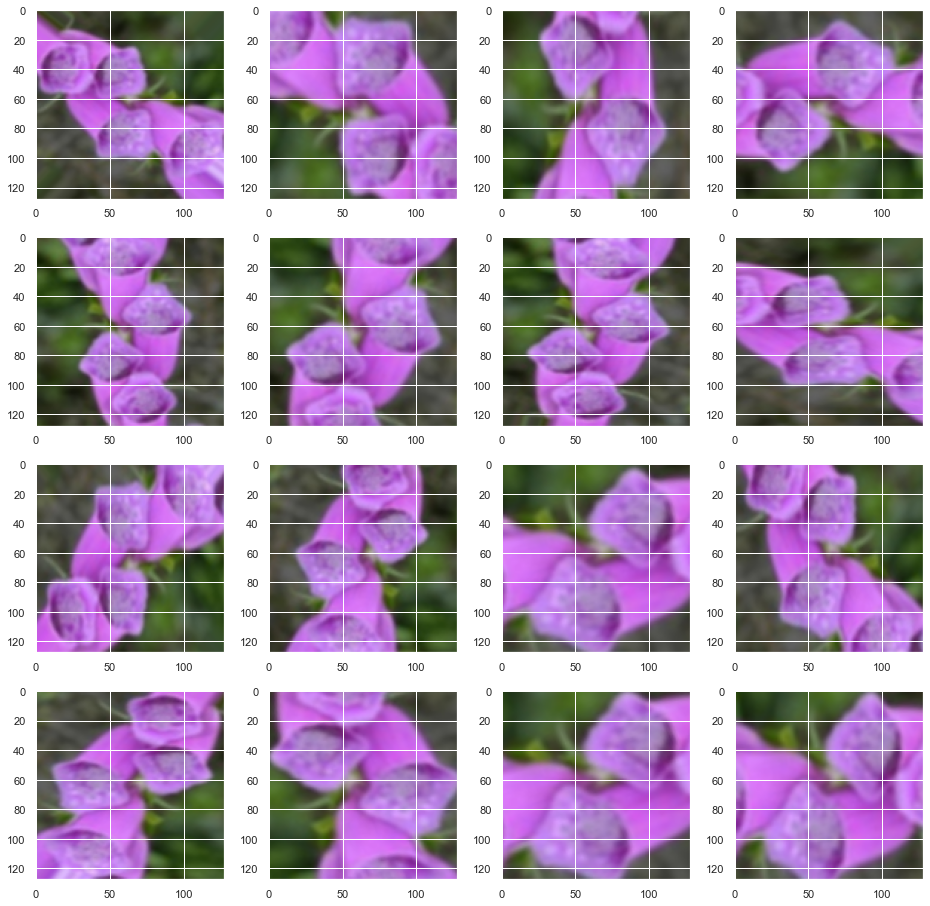

In [16]:
sample = x_train[0].reshape(1,128,128,3)
it = datagen.flow(sample)
plt.figure(figsize=(16, 16))
# generate batch of images
for i in range(1,17):
	# convert to unsigned integers
	image = next(it)[0].astype('uint8')
	plt.subplot(4, 4, i)
	plt.imshow(image)
plt.show()

models are overfitting quite a bit so we will try adding regularization to layers that have the attribute

In [17]:
def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

#define early stopping to stop training when performance doesn't improve
es = EarlyStopping(
    monitor='val_accuracy',
    patience = 3, 
)

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train_oh)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test_oh)).batch(32)

### Resnet

In [18]:
augmented_flow,validation_flow = get_augmented_flow(rescale=False)

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=102,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(102, activation='softmax'))
add_regularization(resnet_model)
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

resnet_history = resnet_model.fit(augmented_flow, validation_data=validation_flow, epochs=20)

Epoch 1/20
192/192 [==============================] - 29s 116ms/step - loss: 2.2243 - accuracy: 0.4670 - val_loss: 1.3867 - val_accuracy: 0.6313
Epoch 2/20
192/192 [==============================] - 20s 104ms/step - loss: 1.1488 - accuracy: 0.6790 - val_loss: 1.1323 - val_accuracy: 0.6978
Epoch 3/20
192/192 [==============================] - 20s 102ms/step - loss: 0.8939 - accuracy: 0.7419 - val_loss: 1.0220 - val_accuracy: 0.7217
Epoch 4/20
192/192 [==============================] - 20s 102ms/step - loss: 0.7584 - accuracy: 0.7728 - val_loss: 1.0029 - val_accuracy: 0.7324
Epoch 5/20
192/192 [==============================] - 20s 102ms/step - loss: 0.6823 - accuracy: 0.7989 - val_loss: 0.9593 - val_accuracy: 0.7354
Epoch 6/20
192/192 [==============================] - 20s 102ms/step - loss: 0.6103 - accuracy: 0.8171 - val_loss: 0.9002 - val_accuracy: 0.7480
Epoch 7/20
192/192 [==============================] - 20s 102ms/step - loss: 0.5861 - accuracy: 0.8276 - val_loss: 0.9148 - val_ac

In [20]:
resnet_model.fit(augmented_flow, validation_data=validation_flow, epochs=20)

Epoch 1/20
192/192 [==============================] - 21s 107ms/step - loss: 0.3403 - accuracy: 0.8943 - val_loss: 0.9377 - val_accuracy: 0.7754
Epoch 2/20
192/192 [==============================] - 21s 110ms/step - loss: 0.3007 - accuracy: 0.9051 - val_loss: 0.9239 - val_accuracy: 0.7881
Epoch 3/20
192/192 [==============================] - 21s 110ms/step - loss: 0.2951 - accuracy: 0.9073 - val_loss: 0.8619 - val_accuracy: 0.7881
Epoch 4/20
192/192 [==============================] - 21s 110ms/step - loss: 0.3024 - accuracy: 0.9023 - val_loss: 0.9529 - val_accuracy: 0.7808
Epoch 5/20
192/192 [==============================] - 21s 111ms/step - loss: 0.3015 - accuracy: 0.9083 - val_loss: 0.8877 - val_accuracy: 0.7979
Epoch 6/20
192/192 [==============================] - 21s 111ms/step - loss: 0.2871 - accuracy: 0.9114 - val_loss: 0.9866 - val_accuracy: 0.7769
Epoch 7/20
192/192 [==============================] - 23s 117ms/step - loss: 0.2778 - accuracy: 0.9152 - val_loss: 0.9529 - val_ac

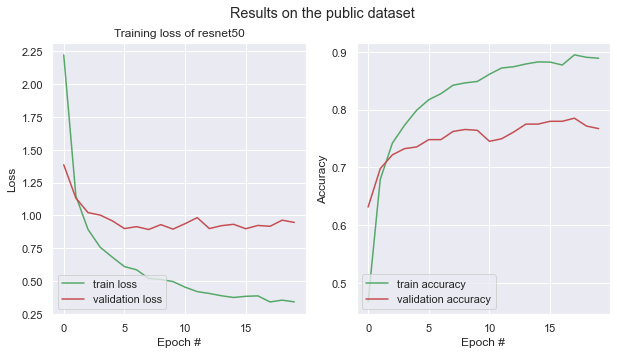

In [36]:
plot_history(resnet_history, "resnet50")

In [21]:
predictions = predict(resnet_model, x_test)

In [22]:
f1_score(y_test, predictions, average='weighted')

0.7903164982557775

In [23]:
bootstrap_score(predictions, y_test)

(0.8443601395128396, 0.8477967969550194)
bootstrap score for model  0.8460784682339295 +/-  0.0017183287210899012


(0.8443601395128396, 0.8477967969550194)

In [29]:
augmented_flow,validation_flow = get_augmented_flow(rescale=False)

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=102,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(102, activation='softmax'))
add_regularization(resnet_model)
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

resnet_history = resnet_model.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
192/192 [==============================] - 20s 96ms/step - loss: 1.8801 - accuracy: 0.5584 - val_loss: 1.0560 - val_accuracy: 0.7095
Epoch 2/5
192/192 [==============================] - 18s 92ms/step - loss: 0.5785 - accuracy: 0.8398 - val_loss: 0.8510 - val_accuracy: 0.7661
Epoch 3/5
192/192 [==============================] - 18s 92ms/step - loss: 0.2874 - accuracy: 0.9262 - val_loss: 0.8003 - val_accuracy: 0.7788
Epoch 4/5
192/192 [==============================] - 18s 93ms/step - loss: 0.1619 - accuracy: 0.9629 - val_loss: 0.8410 - val_accuracy: 0.7886
Epoch 5/5
192/192 [==============================] - 18s 92ms/step - loss: 0.0991 - accuracy: 0.9803 - val_loss: 0.7680 - val_accuracy: 0.7959


In [30]:
predictions = predict(resnet_model, x_test)

In [31]:
print(f1_score(y_test, predictions, average='weighted'))
bootstrap_score(predictions, y_test)

0.7987113370855325
(0.7906960215550954, 0.7940266936773149)
bootstrap score for model  0.7923613576162052 +/-  0.0016653360611097456


(0.7906960215550954, 0.7940266936773149)

### Xception

In [20]:
Xception_model = Sequential()

pretrained_model = tf.keras.applications.Xception(
                include_top = False, 
                input_shape=(128,128,3),
                pooling='avg',classes=102,
                weights='imagenet'
)

Xception_model.add(pretrained_model)
Xception_model.add(Flatten())
Xception_model.add(Dense(512, activation='relu'))
Xception_model.add(Dense(102, activation='softmax'))

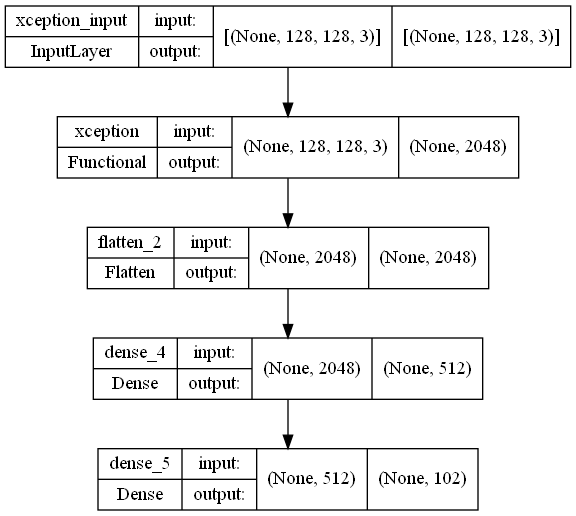

In [21]:
plot_model(Xception_model, show_shapes=True, show_layer_names=True)

In [67]:
Xception_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
augmented_flow, validation_flow = get_augmented_flow(rescale=True)
history_xception = Xception_model.fit(augmented_flow, epochs=50, validation_data=augmented_flow, callbacks=[es])

Epoch 1/50
192/192 [==============================] - 94s 474ms/step - loss: 2.6652 - accuracy: 0.3784 - val_loss: 2.8897 - val_accuracy: 0.3897
Epoch 2/50
192/192 [==============================] - 88s 460ms/step - loss: 1.3330 - accuracy: 0.6444 - val_loss: 1.9621 - val_accuracy: 0.5125
Epoch 3/50
192/192 [==============================] - 83s 432ms/step - loss: 0.9269 - accuracy: 0.7474 - val_loss: 0.8507 - val_accuracy: 0.7732
Epoch 4/50
192/192 [==============================] - 82s 428ms/step - loss: 0.7515 - accuracy: 0.7912 - val_loss: 0.9014 - val_accuracy: 0.7627
Epoch 5/50
192/192 [==============================] - 82s 428ms/step - loss: 0.6182 - accuracy: 0.8222 - val_loss: 0.7097 - val_accuracy: 0.8038
Epoch 6/50
192/192 [==============================] - 73s 380ms/step - loss: 0.5585 - accuracy: 0.8416 - val_loss: 0.8595 - val_accuracy: 0.7798
Epoch 7/50
192/192 [==============================] - 66s 343ms/step - loss: 0.4855 - accuracy: 0.8570 - val_loss: 0.7887 - val_ac

In [70]:
Xception_model.save('Xception-model')

INFO:tensorflow:Assets written to: Xception-model\assets


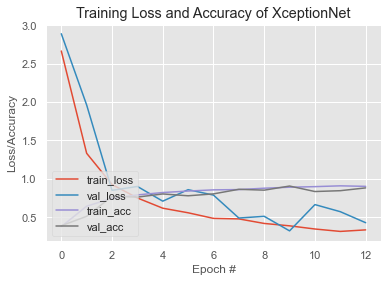

In [71]:
plot_history(history_xception, "XceptionNet")

In [37]:
Xception_model = tf.keras.models.load_model('Xception-model')

In [40]:
f1_score(y_test, predict(Xception_model, x_test/255), average='weighted')

0.9310445790089904

In [41]:
bootstrap_score(predictions =predict(Xception_model, x_test/255), gold = y_test, alpha= 0.9)

(0.9052746050690227, 0.9075231443847062)
bootstrap score for model  0.9063988747268644 +/-  0.0011242696578417366


(0.9052746050690227, 0.9075231443847062)

### EfficientNet

In [38]:
augmented_flow, validation_flow = get_augmented_flow(rescale = False)
EfficientNet_model = Sequential()
pretrained_model = tf.keras.applications.EfficientNetV2S(
    include_top = False, 
                input_shape=(128,128,3),
                pooling='avg',classes=102,
                weights='imagenet'
)
for layer in pretrained_model.layers:
        layer.trainable=False


EfficientNet_model.add(pretrained_model)
EfficientNet_model.add(Flatten())
EfficientNet_model.add(Dense(512, activation='relu'))
EfficientNet_model.add(Dense(102, activation='softmax'))
EfficientNet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history_Effnet= EfficientNet_model.fit(augmented_flow, epochs=50, validation_data=validation_flow)


Epoch 1/50
192/192 [==============================] - 35s 150ms/step - loss: 3.9520 - accuracy: 0.1723 - val_loss: 3.3464 - val_accuracy: 0.2827
Epoch 2/50
192/192 [==============================] - 27s 139ms/step - loss: 2.7370 - accuracy: 0.4315 - val_loss: 2.3810 - val_accuracy: 0.4951
Epoch 3/50
192/192 [==============================] - 27s 139ms/step - loss: 1.9867 - accuracy: 0.5844 - val_loss: 1.8333 - val_accuracy: 0.6108
Epoch 4/50
192/192 [==============================] - 27s 139ms/step - loss: 1.5642 - accuracy: 0.6753 - val_loss: 1.5316 - val_accuracy: 0.6665
Epoch 5/50
192/192 [==============================] - 27s 139ms/step - loss: 1.3214 - accuracy: 0.7232 - val_loss: 1.3308 - val_accuracy: 0.7070
Epoch 6/50
192/192 [==============================] - 27s 139ms/step - loss: 1.1366 - accuracy: 0.7569 - val_loss: 1.1900 - val_accuracy: 0.7261
Epoch 7/50
192/192 [==============================] - 27s 139ms/step - loss: 0.9961 - accuracy: 0.7836 - val_loss: 1.0886 - val_ac

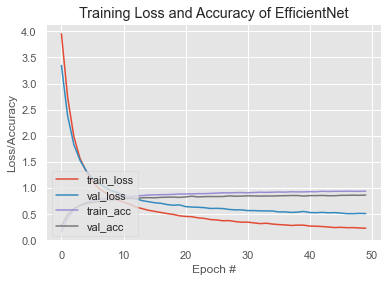

In [41]:
plot_history(history_Effnet, "EfficientNet")

### InceptionResnet

In [50]:
Inception_resnet = Sequential()

pretrained_model = tf.keras.applications.InceptionResNetV2(
                include_top = False, 
                input_shape=(128,128,3),
                pooling='avg',classes=102,
                weights='imagenet'
)
for layer in pretrained_model.layers:
        layer.trainable=False


Inception_resnet.add(pretrained_model)
Inception_resnet.add(Flatten())
Inception_resnet.add(Dense(512, activation='relu'))
Inception_resnet.add(Dense(102, activation='softmax'))
Inception_resnet.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
augmented_flow, validation_flow = get_augmented_flow(rescale = True)
history_Inception= Inception_resnet.fit(augmented_flow, epochs=30, validation_data=validation_flow)

Epoch 1/30
192/192 [==============================] - 42s 184ms/step - loss: 3.7029 - accuracy: 0.2053 - val_loss: 2.9477 - val_accuracy: 0.3076
Epoch 2/30
192/192 [==============================] - 33s 170ms/step - loss: 2.4997 - accuracy: 0.4063 - val_loss: 2.3049 - val_accuracy: 0.4199
Epoch 3/30
192/192 [==============================] - 32s 165ms/step - loss: 2.0109 - accuracy: 0.5033 - val_loss: 1.9522 - val_accuracy: 0.5161
Epoch 4/30
192/192 [==============================] - 31s 164ms/step - loss: 1.7319 - accuracy: 0.5719 - val_loss: 1.7674 - val_accuracy: 0.5415
Epoch 5/30
192/192 [==============================] - 32s 166ms/step - loss: 1.5538 - accuracy: 0.6093 - val_loss: 1.6666 - val_accuracy: 0.5771
Epoch 6/30
192/192 [==============================] - 32s 164ms/step - loss: 1.4275 - accuracy: 0.6411 - val_loss: 1.5511 - val_accuracy: 0.5933
Epoch 7/30
192/192 [==============================] - 32s 165ms/step - loss: 1.3331 - accuracy: 0.6603 - val_loss: 1.4594 - val_ac

### EfficientNetV2L_model

In [54]:
EfficientNetV2L_model = Sequential()

pretrained_model = tf.keras.applications.EfficientNetV2L(
                include_top = False, 
                input_shape=(128,128,3),
                pooling='avg',classes=102,
                weights='imagenet'
)
for layer in pretrained_model.layers:
        layer.trainable=False


EfficientNetV2L_model.add(pretrained_model)
EfficientNetV2L_model.add(Flatten())
EfficientNetV2L_model.add(Dense(512, activation='relu'))
EfficientNetV2L_model.add(Dense(102, activation='softmax'))
EfficientNetV2L_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
augmented_flow, validation_flow = get_augmented_flow(rescale = False)
history_EfficientNetV2L= EfficientNetV2L_model.fit(augmented_flow, epochs=30, validation_data=validation_flow)

Epoch 1/30
192/192 [==============================] - 77s 337ms/step - loss: 4.0132 - accuracy: 0.1713 - val_loss: 3.4697 - val_accuracy: 0.2563
Epoch 2/30
192/192 [==============================] - 56s 293ms/step - loss: 2.8960 - accuracy: 0.3846 - val_loss: 2.5791 - val_accuracy: 0.4492
Epoch 3/30
192/192 [==============================] - 56s 289ms/step - loss: 2.1538 - accuracy: 0.5546 - val_loss: 2.0322 - val_accuracy: 0.5459
Epoch 4/30
192/192 [==============================] - 65s 338ms/step - loss: 1.7149 - accuracy: 0.6437 - val_loss: 1.6964 - val_accuracy: 0.6230
Epoch 5/30
192/192 [==============================] - 60s 312ms/step - loss: 1.4301 - accuracy: 0.7079 - val_loss: 1.4556 - val_accuracy: 0.6772
Epoch 6/30
192/192 [==============================] - 56s 289ms/step - loss: 1.2495 - accuracy: 0.7396 - val_loss: 1.3043 - val_accuracy: 0.7114
Epoch 7/30
192/192 [==============================] - 59s 305ms/step - loss: 1.0950 - accuracy: 0.7681 - val_loss: 1.2097 - val_ac

### DenseNet

In [42]:
Densenet_model = Sequential()

pretrained_model = tf.keras.applications.DenseNet121(
                include_top = False, 
                input_shape=(128,128,3),
                pooling='avg',classes=102,
                weights='imagenet'
)
for layer in pretrained_model.layers:
        layer.trainable=False


Densenet_model.add(pretrained_model)
Densenet_model.add(Flatten())
Densenet_model.add(Dense(512, activation='relu'))
Densenet_model.add(Dense(102, activation='softmax'))
Densenet_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
augmented_flow, validation_flow = get_augmented_flow(rescale = False)
history_Densenet= Densenet_model.fit(augmented_flow, epochs=30, validation_data=validation_flow)

Epoch 1/30
192/192 [==============================] - 29s 121ms/step - loss: 8.4187 - accuracy: 0.0651 - val_loss: 5.3276 - val_accuracy: 0.1118
Epoch 2/30
192/192 [==============================] - 21s 107ms/step - loss: 4.4232 - accuracy: 0.1773 - val_loss: 4.3601 - val_accuracy: 0.1772
Epoch 3/30
192/192 [==============================] - 21s 109ms/step - loss: 3.6653 - accuracy: 0.2400 - val_loss: 3.8453 - val_accuracy: 0.2378
Epoch 4/30
192/192 [==============================] - 21s 108ms/step - loss: 3.2376 - accuracy: 0.2882 - val_loss: 3.5335 - val_accuracy: 0.2612
Epoch 5/30
192/192 [==============================] - 21s 109ms/step - loss: 2.9731 - accuracy: 0.3249 - val_loss: 3.3740 - val_accuracy: 0.2656
Epoch 6/30
192/192 [==============================] - 21s 107ms/step - loss: 2.7361 - accuracy: 0.3569 - val_loss: 3.2731 - val_accuracy: 0.2964
Epoch 7/30
192/192 [==============================] - 21s 108ms/step - loss: 2.6086 - accuracy: 0.3666 - val_loss: 3.1038 - val_ac

In [45]:
f1_score(predict(Densenet_model, x_test), y_test, average='weighted')

0.5369769510913722

In [44]:
bootstrap_score(predict(Densenet_model, x_test), y_test)

(0.4382459672420184, 0.44258407182174103)
bootstrap score for model  0.4404150195318797 +/-  0.0021690522898613063


(0.4382459672420184, 0.44258407182174103)

## vgg16

In [52]:
Vgg_model = Sequential()

pretrained_model = tf.keras.applications.VGG16(
                include_top = False, 
                input_shape=(128,128,3),
                pooling='avg',classes=102,
                weights='imagenet'
)

Vgg_model.add(pretrained_model)
Vgg_model.add(Flatten())
Vgg_model.add(Dense(512, activation='relu'))
Vgg_model.add(Dense(102, activation='softmax'))

In [53]:
Vgg_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
augmented_flow, validation_flow = get_augmented_flow(rescale=False)
history_vgg = Vgg_model.fit(augmented_flow, epochs=50, validation_data=augmented_flow, callbacks=[es])

Epoch 1/50
192/192 [==============================] - 66s 341ms/step - loss: 4.6351 - accuracy: 0.0217 - val_loss: 4.5320 - val_accuracy: 0.0291
Epoch 2/50
192/192 [==============================] - 57s 298ms/step - loss: 4.3910 - accuracy: 0.0490 - val_loss: 4.1637 - val_accuracy: 0.0878
Epoch 3/50
192/192 [==============================] - 58s 300ms/step - loss: 3.8983 - accuracy: 0.0954 - val_loss: 3.4596 - val_accuracy: 0.1252
Epoch 4/50
192/192 [==============================] - 60s 311ms/step - loss: 3.2836 - accuracy: 0.1724 - val_loss: 3.0370 - val_accuracy: 0.2172
Epoch 5/50
192/192 [==============================] - 65s 339ms/step - loss: 2.8636 - accuracy: 0.2493 - val_loss: 2.6106 - val_accuracy: 0.3045
Epoch 6/50
192/192 [==============================] - 75s 389ms/step - loss: 2.5521 - accuracy: 0.3268 - val_loss: 2.3301 - val_accuracy: 0.3773
Epoch 7/50
192/192 [==============================] - 58s 300ms/step - loss: 2.2700 - accuracy: 0.3934 - val_loss: 2.0303 - val_ac

In [55]:
print(f1_score(y_test,predictions,average='weighted'))
bootstrap_score(predictions, y_test)

0.8482775006752276
(0.7334424082161063, 0.7376287184519755)
bootstrap score for model  0.7355355633340409 +/-  0.0020931551179346197


(0.7334424082161063, 0.7376287184519755)

### Vgg19

In [66]:
Vgg_model = Sequential()

pretrained_model = tf.keras.applications.VGG19(
                include_top = False, 
                input_shape=(128,128,3),
                pooling='avg',classes=102,
                weights='imagenet'
)
for layer in pretrained_model.layers:
        layer.trainable=False

Vgg_model.add(pretrained_model)
Vgg_model.add(Flatten())
Vgg_model.add(Dense(512, activation='relu'))
Vgg_model.add(Dense(102, activation='softmax'))

In [68]:
Vgg_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
augmented_flow, validation_flow = get_augmented_flow(rescale=False)
history_vgg = Vgg_model.fit(augmented_flow, epochs=20, validation_data=augmented_flow, callbacks=[es])

Epoch 1/20
192/192 [==============================] - 48s 247ms/step - loss: 6.4497 - accuracy: 0.0609 - val_loss: 4.4399 - val_accuracy: 0.1392
Epoch 2/20
192/192 [==============================] - 48s 250ms/step - loss: 3.8075 - accuracy: 0.2109 - val_loss: 3.2114 - val_accuracy: 0.2754
Epoch 3/20
192/192 [==============================] - 48s 250ms/step - loss: 2.9366 - accuracy: 0.3332 - val_loss: 2.5931 - val_accuracy: 0.3874
Epoch 4/20
192/192 [==============================] - 47s 247ms/step - loss: 2.4529 - accuracy: 0.4148 - val_loss: 2.2612 - val_accuracy: 0.4577
Epoch 5/20
192/192 [==============================] - 48s 249ms/step - loss: 2.1315 - accuracy: 0.4695 - val_loss: 1.9652 - val_accuracy: 0.5058
Epoch 6/20
192/192 [==============================] - 47s 246ms/step - loss: 1.9442 - accuracy: 0.5156 - val_loss: 1.8112 - val_accuracy: 0.5401
Epoch 7/20
192/192 [==============================] - 48s 248ms/step - loss: 1.7506 - accuracy: 0.5551 - val_loss: 1.6776 - val_ac

In [69]:
Vgg_model.fit(augmented_flow, epochs=20, validation_data=augmented_flow, callbacks=[es])

Epoch 1/20
192/192 [==============================] - 45s 234ms/step - loss: 0.9911 - accuracy: 0.7268 - val_loss: 0.9283 - val_accuracy: 0.7424
Epoch 2/20
192/192 [==============================] - 52s 269ms/step - loss: 0.9648 - accuracy: 0.7318 - val_loss: 0.9106 - val_accuracy: 0.7412
Epoch 3/20
192/192 [==============================] - 51s 264ms/step - loss: 0.9304 - accuracy: 0.7422 - val_loss: 0.8769 - val_accuracy: 0.7494
Epoch 4/20
192/192 [==============================] - 48s 252ms/step - loss: 0.9301 - accuracy: 0.7370 - val_loss: 0.9003 - val_accuracy: 0.7447
Epoch 5/20
192/192 [==============================] - 47s 246ms/step - loss: 0.8840 - accuracy: 0.7515 - val_loss: 0.8577 - val_accuracy: 0.7634
Epoch 6/20
192/192 [==============================] - 48s 248ms/step - loss: 0.8654 - accuracy: 0.7575 - val_loss: 0.8221 - val_accuracy: 0.7632
Epoch 7/20
192/192 [==============================] - 48s 251ms/step - loss: 0.8641 - accuracy: 0.7582 - val_loss: 0.8448 - val_ac

In [70]:
predictions = predict(Vgg_model, x_test)

In [74]:
accuracy_score(y_train, predict(Vgg_model, x_train))

0.757368506757857

In [71]:
accuracy_score(y_test, predictions)

0.66748046875

In [72]:
print(f1_score(y_test,predictions,average='weighted'))
bootstrap_score(predictions, y_test)

0.6674253623475302
(0.6166179033818305, 0.620725877476931)
bootstrap score for model  0.6186718904293808 +/-  0.002053987047550221


(0.6166179033818305, 0.620725877476931)

In [80]:
pretrained_model_xception = tf.keras.applications.Xception(
                include_top = False, 
                input_shape=(128,128,3),
                pooling='avg',classes=102,
                weights='imagenet'
)

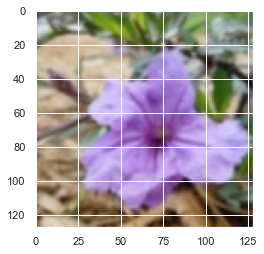

In [124]:
sample = x_train[0]
plt.figure(figsize=(4,4))
plt.imshow(sample)
plt.show()

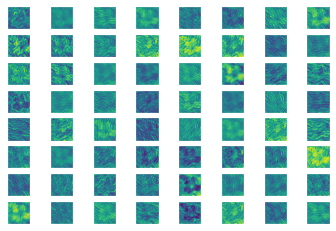

In [120]:
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from matplotlib.pyplot import figure
from keras.preprocessing.image import load_img,img_to_array
model = pretrained_model_xception



layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = 'block2_sepconv2_bn'

model = Model(inputs=model.inputs, outputs=layer_dict[layer_name].output)

# Perpare the image
image = x_train[0]
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

# Apply the model to the image
feature_maps = model.predict(image)

square = 8
index = 1
for _ in range(square):
	for _ in range(square):
        
		ax = plt.subplot(square, square, index)
		ax.set_xticks([])
		ax.set_yticks([])

		plt.imshow(feature_maps[0, :, :, index-1], cmap='viridis')
		index += 1
        

plt.show()

In [110]:
layer_dict

{'input_12': <keras.engine.input_layer.InputLayer at 0x20e56920fa0>,
 'block1_conv1': <keras.layers.convolutional.Conv2D at 0x20e56920220>,
 'block1_conv1_bn': <keras.layers.normalization.batch_normalization.BatchNormalization at 0x20b0b2e9fd0>,
 'block1_conv1_act': <keras.layers.core.activation.Activation at 0x20b09f87280>,
 'block1_conv2': <keras.layers.convolutional.Conv2D at 0x20b1c776370>,
 'block1_conv2_bn': <keras.layers.normalization.batch_normalization.BatchNormalization at 0x20b1c7764c0>,
 'block1_conv2_act': <keras.layers.core.activation.Activation at 0x20b157780d0>,
 'block2_sepconv1': <keras.layers.convolutional.SeparableConv2D at 0x20b157757f0>,
 'block2_sepconv1_bn': <keras.layers.normalization.batch_normalization.BatchNormalization at 0x20b15758b80>,
 'block2_sepconv2_act': <keras.layers.core.activation.Activation at 0x20b156a03d0>,
 'block2_sepconv2': <keras.layers.convolutional.SeparableConv2D at 0x20b1576cd60>,
 'block2_sepconv2_bn': <keras.layers.normalization.batch

## Keras Tuner 

In [23]:
import keras_tuner as kt

tuning output layers

In [24]:
def model_builder(hp):
  model = Sequential()

  pretrained_model = tf.keras.applications.Xception(
                  include_top = False, 
                  input_shape=(128,128,3),
                  pooling='avg',classes=102,
                  weights='imagenet'
  )

  hp_units = hp.Int('units', min_value=512, max_value=2048, step=128)
  model.add(pretrained_model)
  model.add(Flatten())
  model.add(Dense(units = hp_units, activation='relu'))
  model.add(Dense(102, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

  return model

In [25]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [27]:
augmented_flow, validation_flow = get_augmented_flow(rescale=True)

In [29]:
tuner.search(augmented_flow, validation_data = validation_flow, epochs = 100, callbacks = [stop_early])

INFO:tensorflow:Oracle triggered exit


## Grid Search

In [14]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

optimizer = ['SGD', 'adam', 'RMSprop', 'Adagrad', 'Adamax']
param_grid = dict(optimizer = optimizer)

In [18]:
def create_model(optimizer = 'adam'):
	# create model
	Xception_model = Sequential()
	pretrained_model = tf.keras.applications.Xception(
		include_top=False,
		weights="imagenet",
		input_shape=(128,128,3),
		classes=102
	)
	for layer in pretrained_model.layers:
			layer.trainable=False

	Xception_model.add(pretrained_model)
	Xception_model.add(Flatten())
	Xception_model.add(Dense(512, activation='relu'))
	Xception_model.add(Dense(102, activation='softmax'))
	# Compile model
	Xception_model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
	return Xception_model

In [22]:
def grid_search(create_model, X,y):
    model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=10)
    grid_result = grid.fit(X,y)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid, grid_result

In [23]:
grid, res = grid_search(create_model, x_train/255, y_train_oh)

C:\Users\Fedy\AppData\Local\Temp\ipykernel_19472\3879805718.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START optimizer=SGD...............................................
[CV 1/3; 1/5] END ................optimizer=SGD;, score=0.715 total time= 1.6min
[CV 2/3; 1/5] START optimizer=SGD...............................................
[CV 2/3; 1/5] END ................optimizer=SGD;, score=0.714 total time= 1.5min
[CV 3/3; 1/5] START optimizer=SGD...............................................
[CV 3/3; 1/5] END ..................optimizer=SGD;, score=nan total time=  11.8s
[CV 1/3; 2/5] START optimizer=adam..............................................
[CV 1/3; 2/5] END .................optimizer=adam;, score=nan total time=  11.7s
[CV 2/3; 2/5] START optimizer=adam..............................................
[CV 2/3; 2/5] END .................optimizer=adam;, score=nan total time=  11.5s
[CV 3/3; 2/5] START optimizer=adam..............................................
[CV 3/3; 2/5] END ...............optimizer=adam;,

C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Python39\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Python39\lib\site-packages\keras\utils\trace

Best: 0.712425 using {'optimizer': 'RMSprop'}
nan (nan) with: {'optimizer': 'SGD'}
nan (nan) with: {'optimizer': 'adam'}
0.712425 (0.005988) with: {'optimizer': 'RMSprop'}
nan (nan) with: {'optimizer': 'Adagrad'}
nan (nan) with: {'optimizer': 'Adamax'}


In [ ]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
print("Submit this file to codalab:\n" + sample_code_submission)